In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

data = {
    "CustomerID": range(1, 501),
    "OrderFrequency": np.random.randint(1, 40, 500),
    "LastOrderDays": np.random.randint(1, 60, 500),
    "Rating": np.round(np.random.uniform(1, 5, 500), 1),
    "Complaints": np.random.randint(0, 6, 500)
}

df = pd.DataFrame(data)

# Create churn logic (realistic assumption)
df["Churn"] = np.where(
    (df["LastOrderDays"] > 30) | (df["Rating"] < 3) | (df["Complaints"] > 3),
    1,
    0
)

df.head()


,CustomerID,OrderFrequency,LastOrderDays,Rating,Complaints,Churn
0,1,39,45,3.9,5,1
1,2,29,53,3.1,1,1
2,3,15,42,3.8,2,1
3,4,8,58,4.1,1,1
4,5,21,39,1.3,1,1


In [4]:
# Check missing values
df.isnull().sum()

# No missing values → dataset clean


CustomerID        0
OrderFrequency    0
LastOrderDays     0
Rating            0
Complaints        0
Churn             0
dtype: int64

In [12]:
df["AvgOrderGap"] = df["LastOrderDays"] / df["OrderFrequency"]
df["OrderRatingScore"] = df["OrderFrequency"] * df["Rating"]
# df["AvgOrderGap"] = df["AvgOrderGap"].round()
df["AvgOrderGap"] = df["AvgOrderGap"].astype(int)

df.head()

,CustomerID,OrderFrequency,LastOrderDays,Rating,Complaints,Churn,AvgOrderGap,OrderRatingScore
0,1,39,45,3.9,5,1,1,152.1
1,2,29,53,3.1,1,1,1,89.9
2,3,15,42,3.8,2,1,2,57.0
3,4,8,58,4.1,1,1,7,32.8
4,5,21,39,1.3,1,1,1,27.3


📐 Step 4: Prepare Data for Modeling

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    "OrderFrequency",
    "LastOrderDays",
    "Rating",
    "Complaints",
    "AvgOrderGap",
    "OrderRatingScore"
]

X = df[features]
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



🤖 Step 5: Build Logistic Regression Model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.912
              precision    recall  f1-score   support

           0       0.87      0.59      0.70        22
           1       0.92      0.98      0.95       103

    accuracy                           0.91       125
   macro avg       0.89      0.79      0.83       125
weighted avg       0.91      0.91      0.91       125



📉 Step 6: Predict Churn Probability

In [21]:
df["ChurnProbability"] = model.predict_proba(
    scaler.transform(df[features])
)[:, 1]


🎯 Step 7: Identify High-Risk Customers

In [22]:
high_risk_customers = df[df["ChurnProbability"] > 0.7]

high_risk_customers[[
    "CustomerID",
    "ChurnProbability",
    "OrderFrequency",
    "Rating",
    "Complaints"
]].head()

,CustomerID,ChurnProbability,OrderFrequency,Rating,Complaints
0,1,0.997924,39,3.9,5
1,2,0.995179,29,3.1,1
2,3,0.963196,15,3.8,2
3,4,0.983274,8,4.1,1
4,5,0.999039,21,1.3,1


💡 Step 8: Recommend Retention Actions

In [23]:
def recommend_offer(row):
    if row["Rating"] < 3:
        return "Apology + Quality Improvement Coupon"
    elif row["Complaints"] > 3:
        return "Customer Support Callback + Cashback"
    elif row["OrderFrequency"] < 5:
        return "Free Delivery + 30% Discount"
    else:
        return "Loyalty Points Boost"

df["RetentionOffer"] = df.apply(recommend_offer, axis=1)


In [24]:
df

,CustomerID,OrderFrequency,LastOrderDays,Rating,Complaints,Churn,AvgOrderGap,OrderRatingScore,ChurnProbability,RetentionOffer
0,1,39,45,3.9,5,1,1,152.1,0.997924,Customer Support Callback + Cashback
1,2,29,53,3.1,1,1,1,89.9,0.995179,Loyalty Points Boost
2,3,15,42,3.8,2,1,2,57.0,0.963196,Loyalty Points Boost
3,4,8,58,4.1,1,1,7,32.8,0.983274,Loyalty Points Boost
4,5,21,39,1.3,1,1,1,27.3,0.999039,Apology + Quality Improvement Coupon
...,...,...,...,...,...,...,...,...,...,...
495,496,21,54,4.8,3,1,2,100.8,0.976279,Loyalty Points Boost
496,497,36,4,1.7,0,1,0,61.2,0.817272,Apology + Quality Improvement Coupon
497,498,23,19,4.1,3,0,0,94.3,0.652370,Loyalty Points Boost
498,499,16,20,3.8,2,0,1,60.8,0.617364,Loyalty Points Boost


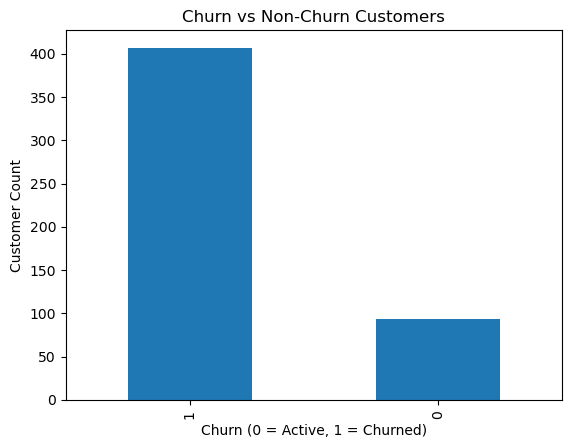

In [25]:
import matplotlib.pyplot as plt

plt.figure()
df["Churn"].value_counts().plot(kind="bar")
plt.title("Churn vs Non-Churn Customers")
plt.xlabel("Churn (0 = Active, 1 = Churned)")
plt.ylabel("Customer Count")
plt.show()


⏳ 2. Average Last Order Days by Churn

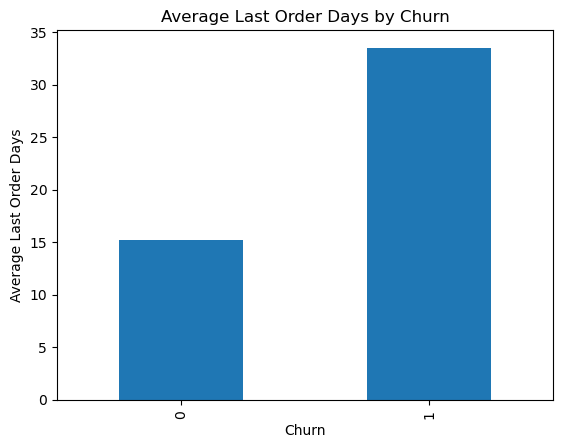

In [26]:
plt.figure()
df.groupby("Churn")["LastOrderDays"].mean().plot(kind="bar")
plt.title("Average Last Order Days by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Last Order Days")
plt.show()


⭐ 3. Average Rating by Churn

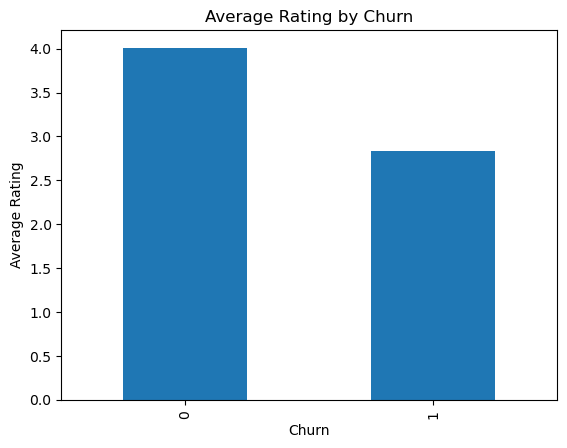

In [27]:
plt.figure()
df.groupby("Churn")["Rating"].mean().plot(kind="bar")
plt.title("Average Rating by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Rating")
plt.show()


⚠️ 4. Average Complaints by Churn

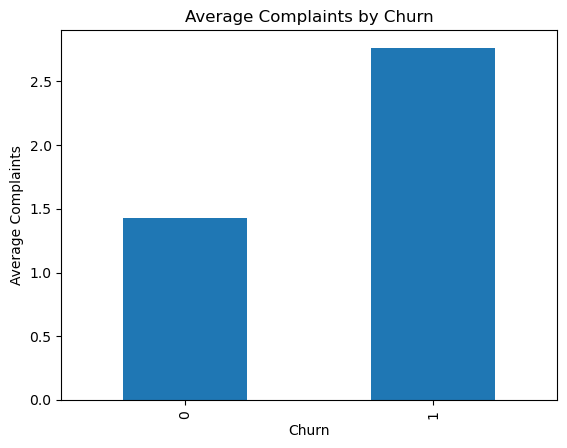

In [28]:
plt.figure()
df.groupby("Churn")["Complaints"].mean().plot(kind="bar")
plt.title("Average Complaints by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Complaints")
plt.show()


📉 5. Churn Probability Distribution

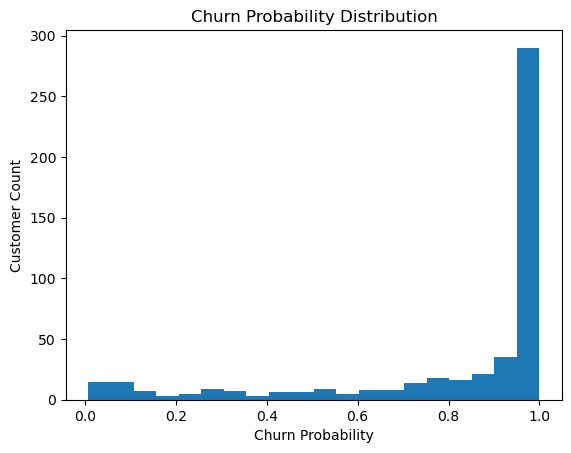

In [29]:
plt.figure()
plt.hist(df["ChurnProbability"], bins=20)
plt.title("Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Customer Count")
plt.show()
